# Synchronous Advantage Actor-Critic (A2C)

This is the A2C algorithm with a discrete action space (only works on environments with discrete actions). Synchronous Advantage Actor-Critic (A2C) is an actor-critic method which runs multiple environments in parallel. A2C is a synchronous version of the asynchronous algorithm A3C. The updates will be performed in a Monte-Carlo way (parameter updates will only be performed at the end of the episode). This is an actor-critic implementation since bootstrapping is used to estimate the return for non-terminal states in addition to the policy gradient used for choosing the actions.

The advantage function, $A^{\pi}$, following policy $\pi$ is defined by:
$$A^{\pi} = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t),$$
where $Q^{\pi}(s_t, a_t)$ is the action-value function following policy $\pi$ and $V^{\pi}(s_t)$ is the state-value function following policy $\pi$. The advantage function essentially measures the advantage gained (or lost) by taking the action $a_t$ in state $s_t$ over the average return of all immediate actions, and then following policy $\pi$ in the following states. We don't know the absolute value of the advantage, $A^{\pi}$, hence we need to find an advantage estimate, $\hat{A}$, as a substitute.

The advantage estimate used in A2C/A3C is given by:
$$\hat{A}_{t} = G_t - \hat{v}(S_t, w),$$ 
where $G_t$ is the discounted return for terminal episodes or the bootstrapped return for non-terminal episodes, and $\hat{v}(S_t, w)$ is the value estimate given state $S_t$ and parameters $w$. The bias-variance trade-off can be finetuned by altering the discount rate $\gamma$. Larger discount/decay rates lead to higher variance and lower bias and lower discount/decay rates lead to lower variance and higher bias. 


We will be using autograd to perform gradient descent on the policy and value functions. We only need to construct the objective functions (loss functions) and their derivatives will be calculated automatically. We will be using the Adam optimizer for both policy and value gradient updates. The loss functions will be combined into a single loss function. Autograd traces the paths of all the parameters for the gradient calculation, so combining the losses won't impact the gradient calculations. 

The policy objective function is given by:
$$L_{t}^{PF} = -\hat{E_t}[\log(\pi_\theta(a_t | s_t))\hat{A}_{t}].$$

The value objective function is given by:
$$L_{t}^{VF} = \hat{E_t}[\hat{A}_{t}^2].$$

The final objective function is given by:
$$L_{t} = \hat{E_t}[L_{t}^{PF} + c_{1}L_{t}^{VF} - c_{2}S_{\pi_{\theta}}(s_t)],$$
where $S_{\pi_{\theta}}(s_t)$ is the entropy of the policy function, and $c_{1}$, $c_{2}$ are the objective coefficients. Increasing $c_{1}$ will increase the update size on the value function (the same effect as increasing the learning rate) and increasing $c_{2}$ will make the policy function less deterministic. Decreasing the coefficients will have the opposite effect. 


For more information on A2C/A3C, see the original A3C paper [1] [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783), the notebook [2] [RL-Adventure-2 Actor-Critic Notebook](https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb).


In [11]:
import os
import random
import numpy as np
from functools import partial
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import jax
import flax.linen as nn
from jax import grad, value_and_grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from vec_env.subproc_vec_env import SubprocVecEnv
# Print numpy array floats with 2 decimal places
np.set_printoptions(precision=2, suppress=True)

In [12]:
# Type of environment, options include:
# CartPole-v1, MountainCar-v0, LunarLander-v2, Acrobot-v1
ENV_TYPE = "LunarLander-v2"
# Choose number of parallel environments, 
# don't exceed the number of computer threads
num_envs = 10

# Save videos from training
SAVE_VIDEOS = True
VIDEOS_ROOT_DIR = './videos/a2c_discrete/'

In [13]:
def make_env(env_id):
    """
    Returns a single environment object, 
    which will be used for parallel execution.
    """
    def _init():
        env = gym.make(env_id)
        return env
    return _init

In [14]:
# Create multiple envs for parallel execution
envs = SubprocVecEnv([make_env(ENV_TYPE) for _ in range(num_envs)])

num_actions = envs.action_space.n
obs_dims = envs.observation_space.shape
obs_upper_bounds = envs.observation_space.high
obs_lower_bounds = envs.observation_space.low

## Create The Policy 

In [15]:
class _policy_fn(nn.Module):
    """
    Policy function is an MLP used to choose the 
    best possible discrete action given the observations from the state.
    Each discrete action is given a probability from 0-1.
    The probability distribution can then be used 
    to stocastically choose the next action.  
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn()
# Display the model details
dummy_x = envs.reset()
dummy_x = jnp.array(list(dummy_x[:, 0]))
rng_key = jax.random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))


                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs          ┃ outputs         ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[10,8]   │ float32[10,4]   │                   │
├─────────┼────────────┼─────────────────┼─────────────────┼───────────────────┤
│ Dense_0 │ Dense      │ float32[10,8]   │ float32[10,256] │ bias:             │
│         │            │                 │                 │ float32[256]      │
│         │            │                 │                 │ kernel:           │
│         │            │                 │                 │ float32[8,256]    │
│         │            │                 │                 │                   │
│         │            │                 │                 │ 2,304 (9.2 KB)    │
├─────────┼────────────┼───

/home/ubuntu20/anaconda3/envs/flax/lib/python3.9/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


In [16]:
class _value_fn(nn.Module):
    """
    Value function is an MLP used to predict the expected return (value) 
    given the observations from the state.
    The value can then be used for bootstrapping, and/or 
    calculating the advantage from action chosen in the state. 
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Create the model object
value_fn = _value_fn()
# Display the model details
print(value_fn.tabulate(rng_key, dummy_x))


                               _value_fn Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs          ┃ outputs         ┃ params             ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│         │ _value_fn │ float32[10,8]   │ float32[10,1]   │                    │
├─────────┼───────────┼─────────────────┼─────────────────┼────────────────────┤
│ Dense_0 │ Dense     │ float32[10,8]   │ float32[10,256] │ bias: float32[256] │
│         │           │                 │                 │ kernel:            │
│         │           │                 │                 │ float32[8,256]     │
│         │           │                 │                 │                    │
│         │           │                 │                 │ 2,304 (9.2 KB)     │
├─────────┼───────────┼─────────────────┼─────────────────┼────────────────────┤
│ Dense_1 │ Dense     │ flo

In [17]:
def test_model(policy_variables, env, rng_key):
    """
    Runs a single episode following the policy function, 
    then returns the episodes rewards and steps.
    Args:
        policy_variables: Policy functions model parameters.
        env: Environment used to interact with.
        rng_key: Random number generator key.
    Returns:
        steps: Number of environment steps.
        episode_rewards: List of rewards from the episode.
    """

    terminated, truncated = False, False
    episode_rewards = []
    steps = 0

    state, _ = env.reset()
    while not (terminated or truncated):
        steps += 1
        # Select the action following the parametrized policy
        action_dist = policy_fn.apply(policy_variables, state)
        action_dist = jnp.array(action_dist).astype(jnp.float32)
        # Divide by the total to ensure the values sum to one
        action_dist /= action_dist.sum()
        rng_key, subkey = jax.random.split(rng_key)
        action = jax.random.choice(subkey, jnp.arange(num_actions), p=action_dist)
        action = np.array(action)
        next_state, reward, terminated, truncated, info = env.step(action)

        episode_rewards.append(reward)

        state = next_state
    episode_rewards = np.array(episode_rewards)
    return steps, episode_rewards

    

In [18]:
def get_returns(
    gamma, next_value, rewards, done
):
    """
    Get discounted returns from rewards for each environment.
    Args:
        gamma: trajectory discount (scalar).
        next_value: value functions bootstrapped return for next state.
        rewards: agent rewards of taking actions in the environment.
        done: flag list for end of episode, 
            False indicates terminated, and True not terminated.
    Returns:
        Array of returns for each environment at each step.
    """
    R = jnp.squeeze(next_value)
    returns = []

    for t in reversed(range(done.shape[0])):
        R = rewards[t] + (gamma * R * done[t])
        returns.append(R)

    returns = jnp.array(list(reversed(returns)))
    return returns

In [19]:
def loss_fn(value_variables, policy_variables, last_envs, last_states, rng_key, gamma, max_steps, mean_cycle_returns, mean_cycle_steps):
    """
    Runs a single update cycle, 
    then calculates the actor and critic losses, 
    which are then combined and returned.
    The gradients on this loss function are then used 
    to update the policy and actor functions.
    Args:
        value_variables: Value functions model parameters.
        policy_variables: Policy functions model parameters.
        last_envs: List of environments in their previous states.
        last_states: List of states from the prior update cycle or beginning or the episode.
        rng_key: Random number generator key.
        gamma: Discount rate for discounting returns.
        max_steps: Limit on the number of steps in an episode.
        mean_cycle_returns: List of mean returns for each update cycle per environment.
        mean_cycle_steps: List of mean episode steps per update cycle per environment.
    Returns:
        Combined loss of the value and actor functions.
    """
    terminated, truncated, term_or_trunc = jnp.repeat(False, num_envs), jnp.repeat(False, num_envs), jnp.repeat(False, num_envs)
    episode_log_probs = []
    episode_values = []
    episode_rewards = []
    done_flag = []
    states = last_states[0]
    envs = last_envs[0]

    # Follow the policy until max_steps are reached, then update the parameters
    for _ in range(max_steps):
        # Select the action following the parametrized policy
        action_dists = policy_fn.apply(policy_variables, states)
        action_dists = jnp.array(action_dists).astype(jnp.float32)
        # Divide by the total to ensure the values sum to one
        action_dists /= action_dists.sum(axis=1)[..., None]
        # Stocastically choose the next action based on the probability distribution
        actions = []
        for dist in action_dists:
            rng_key, subkey = jax.random.split(rng_key)
            action = jax.random.choice(subkey, jnp.arange(num_actions), p=dist)
            actions.append(action)
        actions = np.array(actions)
        
        next_states, rewards, terminated, truncated, info = envs.step(actions)
        # Check if env was terminated or truncated in this step
        term_or_trunc = jnp.array([term or trunc for term, trunc in zip(terminated, truncated)])
        done_flag.append(term_or_trunc)
        rewards = jnp.array(rewards)
        episode_rewards.append(rewards)
        # Log probabilities are needed for the actor loss
        log_probs = jnp.array([jnp.log(dist[action_index]) for dist, action_index in zip(action_dists, actions)])
        episode_log_probs.append(log_probs)
        # Entropy is used in the loss function to prevent the model from becoming too deterministic
        entropy = jnp.array([-jnp.sum(dist * jnp.log(dist)) for dist in action_dists])
        # Estimate the values given the states, then set all terminated states value to 0
        values = value_fn.apply(value_variables, states)
        values = jnp.squeeze(values)
        values = jnp.array(values, dtype=jnp.float32)
        episode_values.append(values)

        states = next_states

    # Save the last envs/states for the next update cycle
    last_states[0] = states
    last_envs[0] = envs
    # Calculate the mean returns for each environment
    done_flag = np.array(done_flag)
    num_episodes = (done_flag.sum(axis=0) + 1)
    episode_rewards = np.array(episode_rewards)
    sum_rewards = episode_rewards.sum(axis=0)
    mean_returns = sum_rewards / num_episodes
    mean_cycle_returns.append(mean_returns)
    # Calculate mean episode steps per cycle 
    cycle_steps = max_steps / num_episodes
    mean_cycle_steps.append(cycle_steps)
    done_flag = jnp.invert(done_flag)

    # Calculate the advantages
    next_values = value_fn.apply(value_variables, next_states)
    next_values = jnp.squeeze(next_values)
    returns = get_returns(gamma, next_values, episode_rewards, done_flag)
    episode_values = jnp.array(episode_values)
    advantages = returns - episode_values
    # Calculate actor and critic losses, then subtract the entropy 
    episode_log_probs = jnp.array(episode_log_probs)
    actor_loss = -(advantages * episode_log_probs).mean(axis=0)
    critic_loss = (advantages**2).mean(axis=0)
    loss = (actor_loss + 0.5 * critic_loss - 0.001 * entropy).mean()

    return loss

## Learn The Optimal Action-Value Function

In [20]:
# Number of cycles to train on
update_cycles = 201
# Sliding window for update cycle evaluation (needs to be less than num cycles)
cycle_window = 5
# Episode will terminate before max_steps
max_steps = 200
# Discount ratio
gamma = 0.99
# Step size
policy_alpha = 0.001
value_alpha = 0.001

policy_variables = policy_fn.init(rng_key, dummy_x)
policy_optimizer = optax.adam(learning_rate=policy_alpha)
policy_opt_state = policy_optimizer.init(policy_variables)

value_variables = value_fn.init(rng_key, dummy_x)
value_optimizer = optax.adam(learning_rate=value_alpha)
value_opt_state = value_optimizer.init(value_variables)

# Create multiple envs for parallel execution
envs = SubprocVecEnv([make_env(ENV_TYPE) for _ in range(num_envs)])
if SAVE_VIDEOS:
    # Create a single environment for testing
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    test_returns = []
    test_steps = []
    env = gym.make(ENV_TYPE, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 1 == 0,
        video_length=0,
        name_prefix=f"{ENV_TYPE}"
        ) 
losses = []
mean_cycle_returns = []
mean_cycle_steps = []

states = envs.reset()
last_states = [np.array(list(states[:, 0]))]
last_envs = [envs]

for update_step in range(update_cycles):
    print(f"Update Step: {update_step}")
    # Perform 6 tests and record them at even intervals
    if SAVE_VIDEOS and update_step % (update_cycles // 5) == 0:
        test_step, test_rewards = test_model(policy_variables, env, rng_key)
        test_returns.append(np.sum(test_rewards))
        test_steps.append(test_step)
        test_episode = update_step // (update_cycles // 5)
        print(f"\tTest Episode {test_episode} Return: {test_returns[test_episode] :.2f} Steps: {test_steps[test_episode] :.2f}")

    # Run a forward pass on the parallel envs (will last an entire episode) and 
    # calculate the gradients for value and policy functions 
    loss, (value_grads, policy_grads) = value_and_grad(loss_fn, argnums=(0, 1))(
        value_variables, 
        policy_variables, 
        last_envs,
        last_states,
        rng_key, 
        gamma, 
        max_steps,
        mean_cycle_returns,
        mean_cycle_steps
    )
    # Update value function weights
    value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_variables)
    value_variables = optax.apply_updates(value_variables, value_updates)        
    # Update policy function weights
    policy_updates, policy_opt_state = policy_optimizer.update(policy_grads, policy_opt_state, policy_variables)
    policy_variables = optax.apply_updates(policy_variables, policy_updates)


    losses.append(loss)
    print(f'\tAverage Cycle Returns: {mean_cycle_returns[-1]}')
    print(f"\tAverage Return: {mean_cycle_returns[-1].mean() :.2f}")
    print(f"\tLoss: {loss :.2f}")

/home/ubuntu20/anaconda3/envs/flax/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Update Step: 0
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-0.mp4
	Test Episode 0 Return: -151.73 Steps: 103.00
	Average Cycle Returns: [ -36.46  -96.62 -187.01 -114.3  -272.45  -81.25 -121.4  -136.7   -60.92
 -202.89]
	Average Return: -131.00
	Loss: 5404.91
Update Step: 1
	Average Cycle Returns: [ -79.48 -188.87 -124.01 -114.64 -272.5  -192.4  -248.8  -258.58  -79.79
 -132.18]
	Average Return: -169.12
	Loss: 12013.47
Update Step: 2
	Average Cycle Returns: [-181.76 -129.84 -103.85 -100.53 -171.82 -108.45 -159.32 -117.   -143.21
 -179.11]
	Average Return: -139.49
	Loss: 5401.50
Update Step: 3
	Average Cycle Returns: [-164.2  -130.78 -185.89  -89.79 -217.03  -81.29 -119.76  -88.05 -168.4
  -93.08]
	Average Return: -133.83
	Loss: 5800.64
Update Step: 4
	Average Cycle Returns: [-243.7  -239.75 -137.29 -156.86 -117.92 -186.4  -107.81 -174.28  -62.6
 -169.95]
	Average Return: -159.66
	Loss: 7886.92
Update Step: 5
	Average Cycle 

Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-1.mp4
	Test Episode 1 Return: -3.79 Steps: 152.00
	Average Cycle Returns: [ -43.18 -104.    -96.33  -86.02   11.4  -217.08 -194.31  -19.53 -158.09
  -20.98]
	Average Return: -92.81
	Loss: 2600.29
Update Step: 41
	Average Cycle Returns: [ -79.53  -13.49  105.69 -106.06  -33.45 -138.28  -28.27  -30.25 -111.23
 -116.21]
	Average Return: -55.11
	Loss: 2612.19
Update Step: 42
	Average Cycle Returns: [ -83.11  -32.13   97.55  -32.37  -12.27 -179.76  -88.04  -30.63  -47.2
  -74.13]
	Average Return: -48.21
	Loss: 1852.94
Update Step: 43
	Average Cycle Returns: [-162.26 -178.22  -39.9   -24.63  -50.05 -166.05  -70.43  -49.77  -63.46
  -83.11]
	Average Return: -88.79
	Loss: 1899.55
Update Step: 44
	Average Cycle Returns: [-176.48  -94.66   -2.16  -76.36 -108.14 -165.21 -110.67 -101.05  -51.25
  -49.24]
	Average Return: -93.52
	Loss: 2867.00
Update Step: 45
	Average Cycle Re

Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-2.mp4
	Test Episode 2 Return: -58.70 Steps: 107.00
	Average Cycle Returns: [-78.44  50.1  -22.17 -29.38  -6.55 -37.73  -8.83 -36.72 -26.6  -19.19]
	Average Return: -21.55
	Loss: 635.07
Update Step: 81
	Average Cycle Returns: [-22.74 -17.29  -1.35 -23.2  -81.78  -9.07 -43.02 -45.84 -27.3  -58.91]
	Average Return: -33.05
	Loss: 746.06
Update Step: 82
	Average Cycle Returns: [-40.86   4.9  -49.88 -28.2  -25.32 -36.81 -59.77 -27.13   0.55 -36.85]
	Average Return: -29.94
	Loss: 575.40
Update Step: 83
	Average Cycle Returns: [-36.27 -27.52 -38.27 -36.48 -44.56  -9.1  -83.43 -29.36 -49.02 -40.24]
	Average Return: -39.42
	Loss: 741.89
Update Step: 84
	Average Cycle Returns: [-68.77  -3.74 -36.89 -26.99 -48.05  -5.72 -27.36 -35.62 -24.83  30.18]
	Average Return: -24.78
	Loss: 685.46
Update Step: 85
	Average Cycle Returns: [-40.31 -55.53 -19.97 -42.77 -25.31 -25.49 -29.71 -

Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-3.mp4
	Test Episode 3 Return: -41.05 Steps: 122.00
	Average Cycle Returns: [   7.69  -38.88  -13.22 -132.31   10.02  -64.32  -19.15  -19.6   -23.92
   19.53]
	Average Return: -27.42
	Loss: 1480.08
Update Step: 121
	Average Cycle Returns: [ -36.48 -106.25  -13.56  -30.82  -19.5   -83.64   11.53   -2.13  -63.84
  -62.27]
	Average Return: -40.69
	Loss: 1318.23
Update Step: 122
	Average Cycle Returns: [ -93.38  -13.9   -19.07 -135.15  -52.21  -64.13  -14.37  -43.76   20.04
   11.45]
	Average Return: -40.45
	Loss: 2067.91
Update Step: 123
	Average Cycle Returns: [-47.59 -62.97  27.35  43.16 -29.91 -14.64  -5.11 -51.46  -6.31 -16.29]
	Average Return: -16.38
	Loss: 499.53
Update Step: 124
	Average Cycle Returns: [ -25.3   -98.89  -32.74   -3.17  -20.51 -121.4   -15.71  -59.52  -20.45
  -43.52]
	Average Return: -44.12
	Loss: 1102.49
Update Step: 125
	Average Cycle Returns

Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-4.mp4
	Test Episode 4 Return: -295.03 Steps: 789.00
	Average Cycle Returns: [  68.84  -26.76  128.63   -9.24  -47.47  -27.8   -13.41 -115.4    -3.35
  -67.69]
	Average Return: -11.37
	Loss: 1288.81
Update Step: 161
	Average Cycle Returns: [   7.66   14.26 -161.81  -57.91   33.62  -30.48  -55.07  -55.94  -29.04
    4.47]
	Average Return: -33.03
	Loss: 801.13
Update Step: 162
	Average Cycle Returns: [-28.22  54.37 113.06 -60.35 -74.73 -34.36  27.45 -93.13 -15.13  70.25]
	Average Return: -4.08
	Loss: 957.86
Update Step: 163
	Average Cycle Returns: [-30.87  14.77 -11.13  -7.41 -42.83 141.75  78.32  31.62  -5.2  -12.22]
	Average Return: 15.68
	Loss: 788.51
Update Step: 164
	Average Cycle Returns: [ -25.86  -32.46  -20.86  -31.82 -161.99  -78.52  -72.39   -7.23  -61.7
  -79.78]
	Average Return: -57.26
	Loss: 646.20
Update Step: 165
	Average Cycle Returns: [  51.73    2.

Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c_discrete/LunarLander-v2-episode-5.mp4
	Test Episode 5 Return: 28.75 Steps: 169.00
	Average Cycle Returns: [-37.22 132.04 -38.97 -16.25  -4.21 -13.57  20.52 -78.34  66.9  -35.88]
	Average Return: -0.50
	Loss: 313.16


## Plot The Results


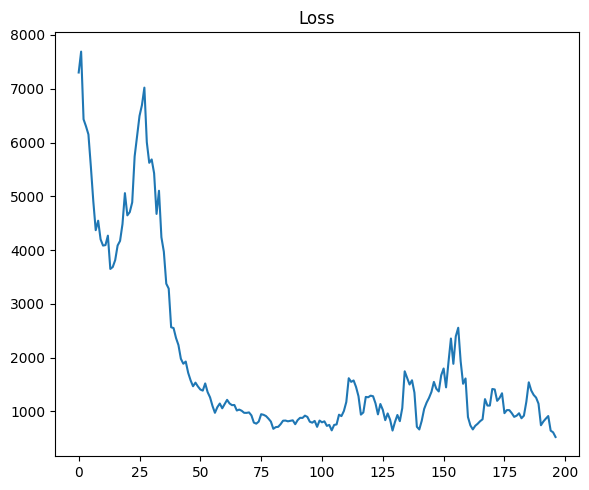

In [21]:
fig, axs = plt.subplots(ncols=1, figsize=(6, 5))
axs.set_title("Loss")
loss_moving_average = (
    np.convolve(
        losses, np.ones(cycle_window), mode="valid"
    )
    / cycle_window
)
axs.plot(range(len(loss_moving_average)), loss_moving_average)
plt.tight_layout()
plt.show()

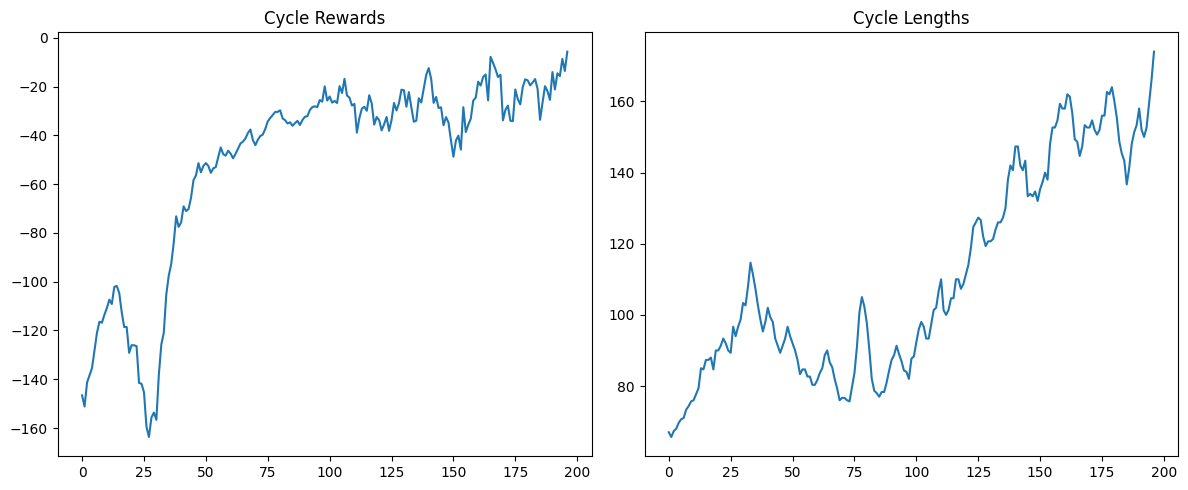

In [22]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Cycle Rewards")
reward_moving_average = (
    np.convolve(
        np.array(mean_cycle_returns).mean(axis=1), np.ones(cycle_window), mode="valid"
    )
    / cycle_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Cycle Lengths")
length_moving_average = (
    np.convolve(
        np.array(mean_cycle_steps).mean(axis=1), np.ones(cycle_window), mode="valid"
    )
    / cycle_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

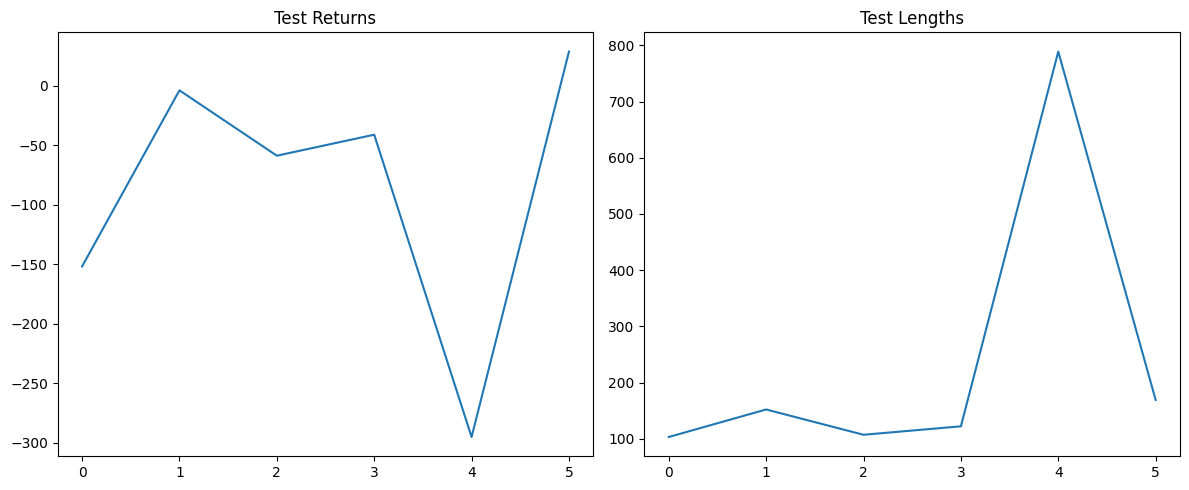

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Test Returns")
axs[0].plot(range(len(test_returns)), test_returns)
axs[1].set_title("Test Lengths")
axs[1].plot(range(len(test_steps)), test_steps)
plt.tight_layout()
plt.show()

## Testing Videos

### Test Episode 0

In [24]:
test_episode = 0
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 0 Return: -151.73494945637776


In [25]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 1

In [26]:
test_episode = 1
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 1 Return: -3.788329697133383


In [27]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 2

In [28]:
test_episode = 2
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 2 Return: -58.69934367351611


In [29]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 3

In [30]:
test_episode = 3
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 3 Return: -41.053799604340725


In [31]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 4

In [32]:
test_episode = 4
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 4 Return: -295.0342794639631


In [33]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 5

In [34]:
test_episode = 5
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 5 Return: 28.7542835006928


In [35]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")